First, some imports...

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

## Read in the data

We're just going to scrape it from their page.

In [2]:
response = requests.get("http://www.thelovesofmarilynmonroe.com/the-lovers/")
doc = BeautifulSoup(response.text, 'html.parser')

In [3]:
loves = doc.find_all(class_="gallery-project")
elements = []
for love in loves:
    element = {
        'name': love.find(class_='project-title').text.title(),
        'occupation': love.find('strong', text=re.compile('.*Occupation.*')).next_sibling,
        'place_of_meeting': love.find('strong', text=re.compile('.*Place.*')).next_sibling,
        'year': love.find('strong', text=re.compile('.*Year.*')).next_sibling,
        'relationship_type': love.find('strong', text=re.compile('.*Type.*')).next_sibling,
        'image_url': love.find('img')['data-src']
    }
    for key in element.keys():
        try:
            element[key] = str(element[key].text)
        except:
            element[key] = str(element[key])
    elements.append(element)
df = pd.DataFrame(elements)
df.head()

,image_url,name,occupation,place_of_meeting,relationship_type,year
0,https://static1.squarespace.com/static/5623852...,Andre De Dienes,Photographer,Photoshoot,Relationship,1945
1,https://static1.squarespace.com/static/5623852...,Arthur Miller,Screenwriter,20th Century Fox,Marriage,1955
2,https://static1.squarespace.com/static/5623852...,Ben Lyon,Actor,20th Century Fox,Romance,1946
3,https://static1.squarespace.com/static/5623852...,Billy Travilla,Costume Designer,Film Set,Romance,1952
4,https://static1.squarespace.com/static/5623852...,"Charlie Chaplin, Jr.",Actor,filmset,Romance,1947


# Building a graph

We'll use the `name` and `place of meeting` columns to try to build a graph, and add in the `year`, `type` and `occupation` columns as edge attributes.

In [4]:
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt

# Ignore matplotlib warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
g = nx.from_pandas_dataframe(df, source='name', target='place_of_meeting', edge_attr=['year', 'relationship_type', 'occupation']) 
g.edges(data=True)

[('Andre De Dienes',
  'Photoshoot',
  {'occupation': 'Photographer',
   'relationship_type': 'Relationship',
   'year': '1945'}),
 ('Photoshoot',
  'David Conover',
  {'occupation': 'Photographer',
   'relationship_type': 'Romance',
   'year': '1945'}),
 ('Arthur Miller',
  '20th Century Fox',
  {'occupation': 'Screenwriter',
   'relationship_type': 'Marriage',
   'year': '1955'}),
 ('20th Century Fox',
  'Ben Lyon',
  {'occupation': 'Actor', 'relationship_type': 'Romance', 'year': '1946'}),
 ('20th Century Fox',
  'Frank Sinatra',
  {'occupation': 'Actor',
   'relationship_type': 'Relationship',
   'year': '1954'}),
 ('20th Century Fox',
  'Hal Schaefer',
  {'occupation': 'Vocal Coach',
   'relationship_type': 'Rumour',
   'year': '1954'}),
 ('20th Century Fox',
  'Joseph Schenck',
  {'occupation': 'Company Owner ',
   'relationship_type': 'Rumour',
   'year': '1947'}),
 ('20th Century Fox',
  'Marlon Brando',
  {'occupation': 'Actor ', 'relationship_type': 'Rumour', 'year': '1955'})

We **don't need to build the graph again**, we can just start drawing it!

## Let's start by pulling the dataframe into a graph...

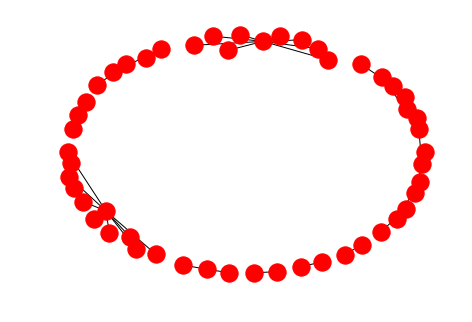

In [6]:
nx.draw(g)

## Which is pretty ugly! So let's style it a little bit...

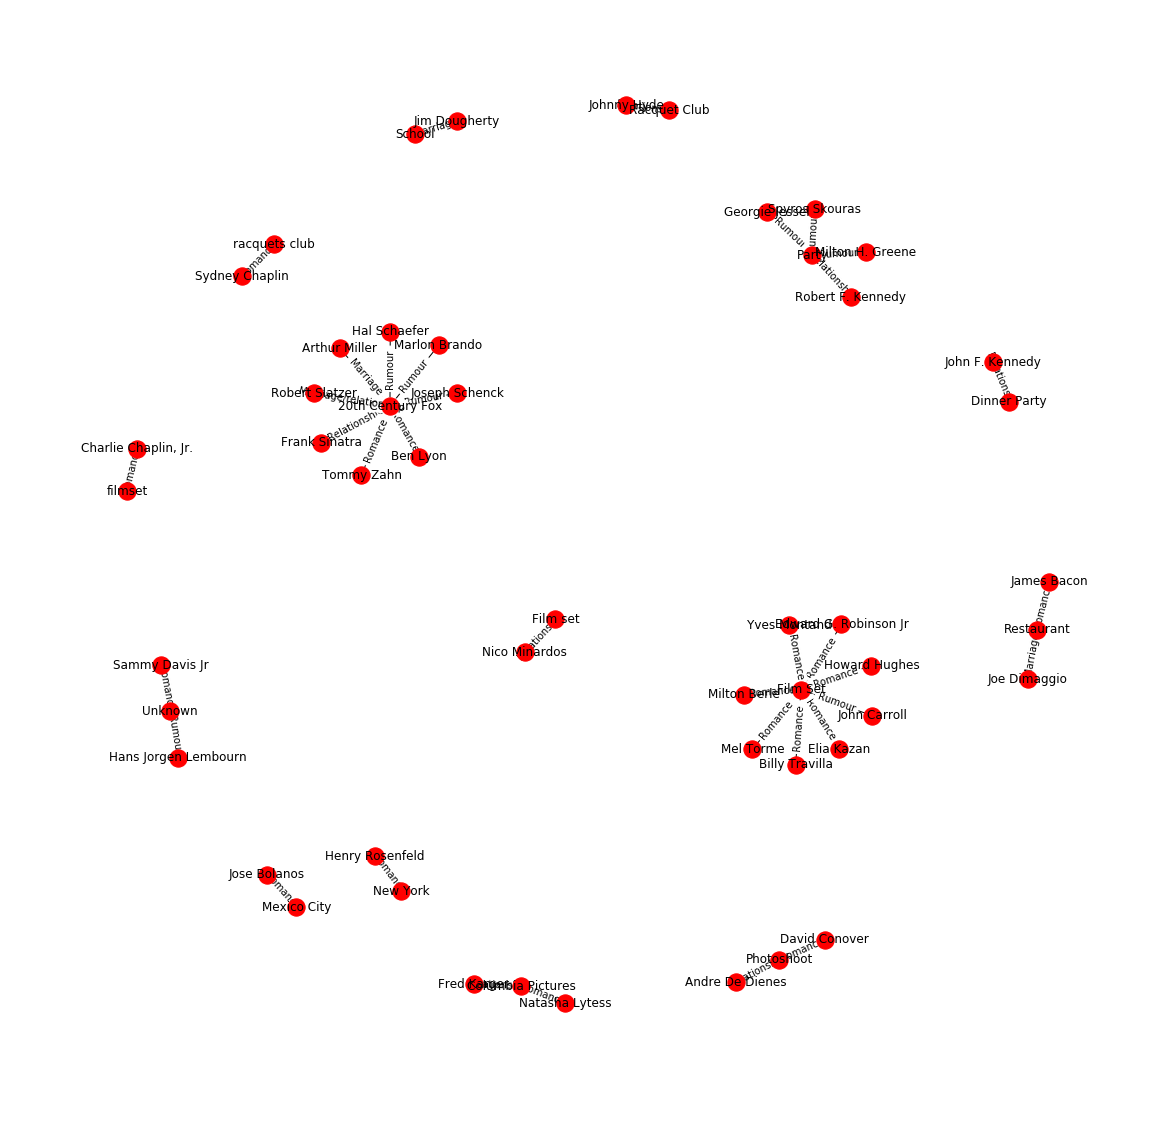

In [11]:
plt.figure(figsize=(20, 20))

# interations: the time before settling down
# k: the distance each node is seperated from one another
layout = nx.spring_layout(g,iterations=40, k=0.05)

nx.draw_networkx_edges(g, layout)
nx.draw_networkx_nodes(g, layout)
nx.draw_networkx_labels(g, layout)

# Edge labels!
labels=dict([((u,v,),data['relationship_type']) for u,v,data in g.edges(data=True)])
nx.draw_networkx_edge_labels(g, layout, edge_labels=labels)

plt.axis('off')

plt.show()

## Coloring the nodes: Places of meeting vs. the relationships

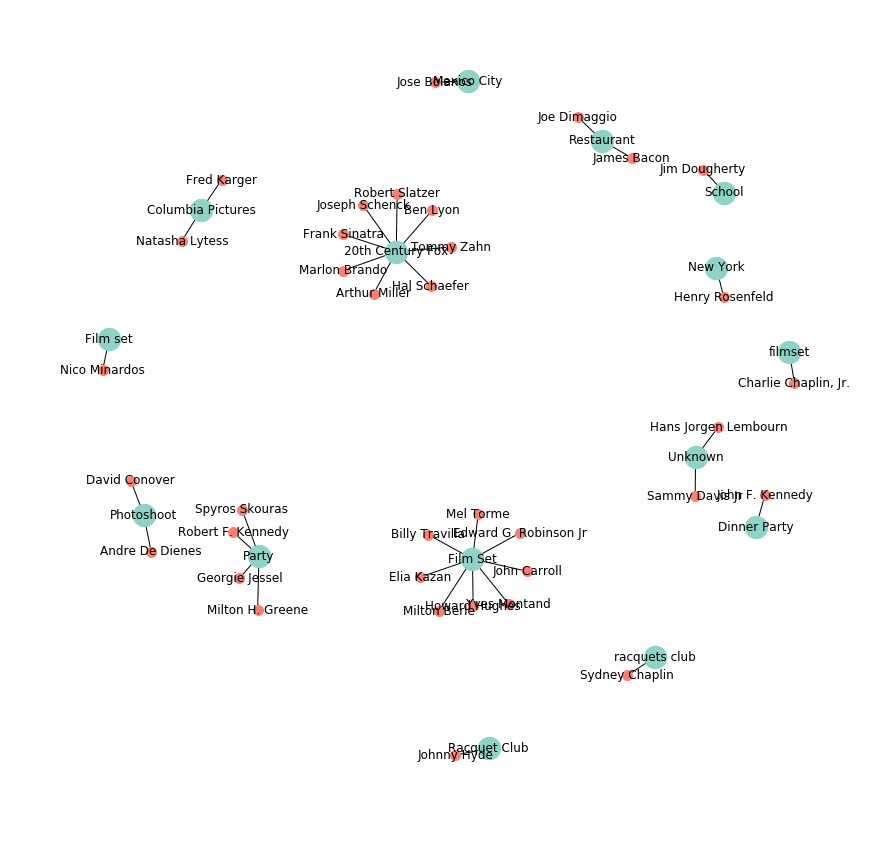

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

g = nx.from_pandas_dataframe(df, source='name', target='place_of_meeting', edge_attr=['relationship_type', 'year', 'occupation']) 

layout = nx.spring_layout(g,iterations=30, k=0.05)

# Pull out the places, draw them
places = [node for node in g.nodes() if node in df.place_of_meeting.unique()]
nx.draw_networkx_nodes(g, layout, nodelist=places, node_color='#8dd3c7', node_size=500)

# Pull out the people, draw them
people = [node for node in g.nodes() if node in df.name.unique()]
nx.draw_networkx_nodes(g, layout, nodelist=people, node_color='#fb8072', node_size=100)

# Draw the edges and the labels
nx.draw_networkx_edges(g, layout)
nx.draw_networkx_labels(g, layout)

plt.axis('off')

plt.show()

# But wait, where's Marilyn?

In [13]:
df.head(3)

,image_url,name,occupation,place_of_meeting,relationship_type,year
0,https://static1.squarespace.com/static/5623852...,Andre De Dienes,Photographer,Photoshoot,Relationship,1945
1,https://static1.squarespace.com/static/5623852...,Arthur Miller,Screenwriter,20th Century Fox,Marriage,1955
2,https://static1.squarespace.com/static/5623852...,Ben Lyon,Actor,20th Century Fox,Romance,1946


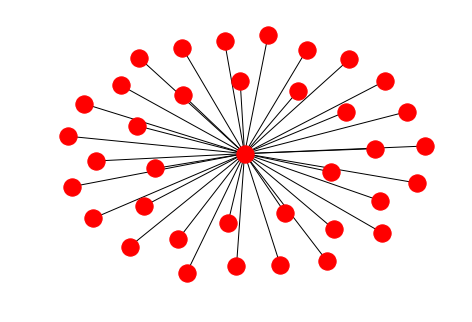

In [14]:
g = nx.Graph()

for i, row in df.iterrows():
    # create a node for Andre, Aurther, etc
    # And add the rest of the row as attributes for that node
    g.add_node(row['name'], attr_dict=row.to_dict())
    g.add_edge("Marilyn Monroe", row['name'])

nx.draw(g)

In [15]:
df.head(3)

,image_url,name,occupation,place_of_meeting,relationship_type,year
0,https://static1.squarespace.com/static/5623852...,Andre De Dienes,Photographer,Photoshoot,Relationship,1945
1,https://static1.squarespace.com/static/5623852...,Arthur Miller,Screenwriter,20th Century Fox,Marriage,1955
2,https://static1.squarespace.com/static/5623852...,Ben Lyon,Actor,20th Century Fox,Romance,1946


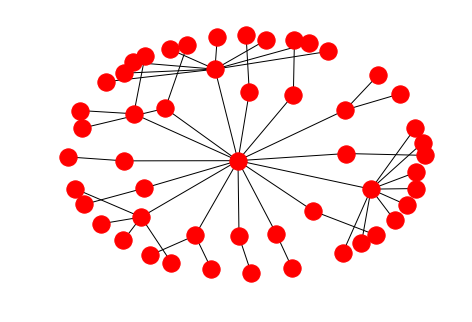

In [16]:
g = nx.Graph()

# We're going to give each node a NODE_TYPE attribute
# so we can pull them apart later and make them
# look different
g.add_node("Marilyn Monroe", node_type='marilyn')

for i, row in df.iterrows():
    # Add the node for the person
    g.add_node(row['name'], node_type='person')
    
    # Add the node for the place of meeting
    g.add_node(row['place_of_meeting'], node_type='place')
    
    # Add a connection from the place to Marilyn Monroe
    # And a connection from the place to the person
    # We'll give these EDGE_TYPEs so we can find them later
    g.add_edge("Marilyn Monroe", row['place_of_meeting'], edge_type='meeting_place')
    g.add_edge(row['place_of_meeting'], row['name'], edge_type=row['relationship_type'])

nx.draw(g)

In [17]:
[edge for edge in g.edges(data=True)]

[('Marilyn Monroe', 'Photoshoot', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', '20th Century Fox', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'Film Set', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'filmset', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'Columbia Pictures', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'Party', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'Unknown', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'New York', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'Restaurant', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'Dinner Party', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'School', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'Racquet Club', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'Mexico City', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'Film set', {'edge_type': 'meeting_place'}),
 ('Marilyn Monroe', 'racquets club', {'edge_type': 'meeting_place

### Let's draw it more nicely

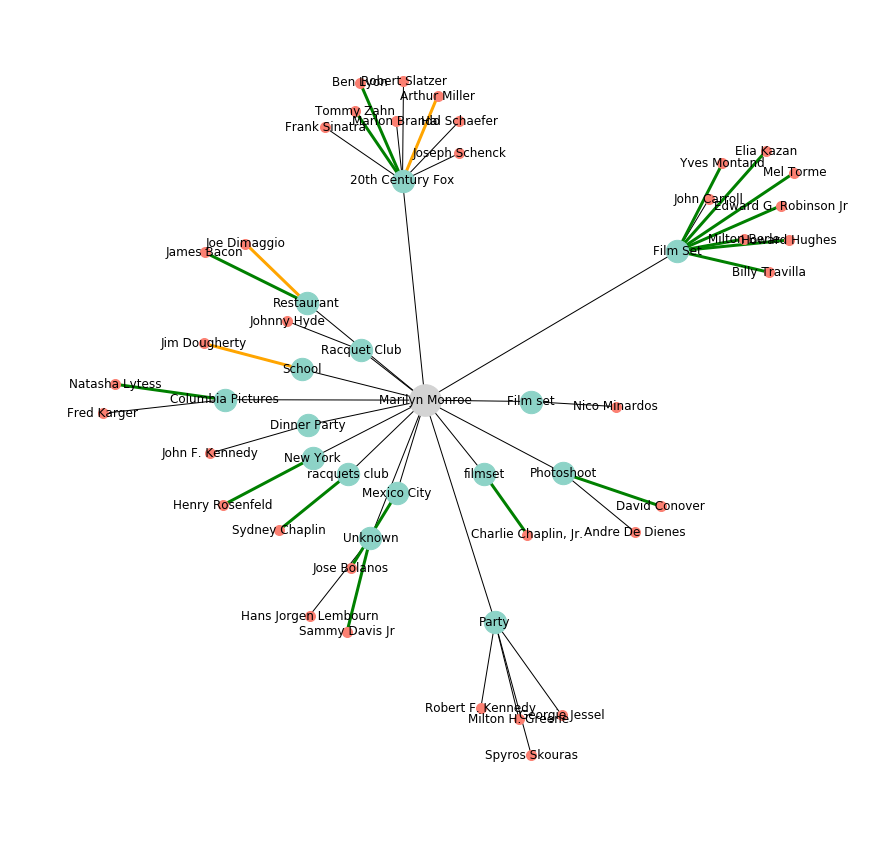

In [18]:
plt.figure(figsize=(15, 15))

layout = nx.spring_layout(g,iterations=50, k=0.05)

nx.draw_networkx_edges(g, layout)

# Highlight the marriages
marriages = [(source, target) for source, target, data in g.edges(data=True) if data['edge_type'] == "Marriage"]
nx.draw_networkx_edges(g, layout, edgelist=marriages, edge_color='orange', width=3)

romances = [(source, target) for source, target, data in g.edges(data=True) if data['edge_type'] == "Romance"]
nx.draw_networkx_edges(g, layout, edgelist=romances, edge_color='green', width=3)

marilyn = [node for node, data in g.nodes(data=True) if data['node_type'] == "marilyn"]
places = [node for node, data in g.nodes(data=True) if data['node_type'] == 'place']
people = [node for node, data in g.nodes(data=True) if data['node_type'] == 'person']

nx.draw_networkx_nodes(g, layout, nodelist=marilyn, node_color='lightgrey', node_size=1000)
nx.draw_networkx_nodes(g, layout, nodelist=places, node_color='#8dd3c7', node_size=500)
nx.draw_networkx_nodes(g, layout, nodelist=people, node_color='#fb8072', node_size=100)

nx.draw_networkx_labels(g, layout)

plt.axis('off')

plt.show()

# Okay, I give up, let's take it somewhere else

## Save it as an adjacency list

In an adjacency list, the ***First Thing*** is your node. Everything after that is nodes that it is connected to.

**Downside**: it doesn't save any extra information.

In [19]:
nx.write_adjlist(g, 'marilyn_adj_list.txt', delimiter=',')

In [20]:
!head -n 10 marilyn_adj_list.txt

#/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py -f /Users/Shiying/Library/Jupyter/runtime/kernel-c4912c79-9bac-424d-be8f-42f4cb2d5c6c.json
# GMT Thu Aug 24 15:50:39 2017
# 
Marilyn Monroe,Photoshoot,20th Century Fox,Film Set,filmset,Columbia Pictures,Party,Unknown,New York,Restaurant,Dinner Party,School,Racquet Club,Mexico City,Film set,racquets club
Andre De Dienes,Photoshoot
Photoshoot,David Conover
Arthur Miller,20th Century Fox
20th Century Fox,Ben Lyon,Frank Sinatra,Hal Schaefer,Joseph Schenck,Marlon Brando,Robert Slatzer,Tommy Zahn
Ben Lyon
Billy Travilla,Film Set


### Save it as an edge list

a list of nodes. The 1st element is a node, the 2nd element is also a node.  and their relationship
No extra infomation is stored.

In [21]:
nx.write_edgelist(g, 'marilyn_edge_list.txt', delimiter=',')

In [22]:
!head -n 5 marilyn_edge_list.txt

Marilyn Monroe,Photoshoot,{'edge_type': 'meeting_place'}
Marilyn Monroe,20th Century Fox,{'edge_type': 'meeting_place'}
Marilyn Monroe,Film Set,{'edge_type': 'meeting_place'}
Marilyn Monroe,filmset,{'edge_type': 'meeting_place'}
Marilyn Monroe,Columbia Pictures,{'edge_type': 'meeting_place'}


### Save it as a GEXF

GEXF is a fancy XML format that you can use a ton of places!

In [23]:
nx.write_gexf(g, 'marilyn.gexf')

In [24]:
!head -n 10 marilyn.gexf

<?xml version='1.0' encoding='utf-8'?>
<gexf version="1.1" xmlns="http://www.gexf.net/1.1draft" xmlns:viz="http://www.gexf.net/1.1draft/viz" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.w3.org/2001/XMLSchema-instance">
  <graph defaultedgetype="undirected" mode="static">
    <attributes class="edge" mode="static">
      <attribute id="1" title="edge_type" type="string" />
    </attributes>
    <attributes class="node" mode="static">
      <attribute id="0" title="node_type" type="string" />
    </attributes>
    <nodes>


## How do we open this?

Go get [Gephi](https://gephi.org/)